In [1]:
import torch
from math import sqrt
from simple_fem import get_cantilever
import matplotlib.pyplot as plt

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14

torch.set_default_dtype(torch.double)

## Define the cantilever problem

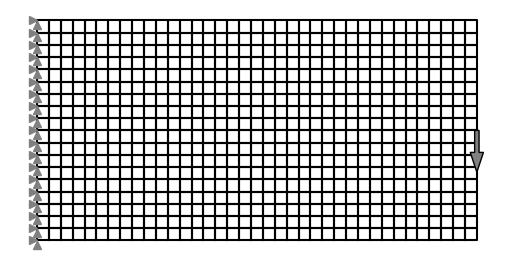

In [2]:
cantilever = get_cantilever(0.75, 28.0, 14.0)
cantilever.plot()

## Optimization with MMA

In [3]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize_mma(fem, rho_0, rho_min, rho_max, V_0, iter=15, s=0.9, p=1.0, r_sens=0.0):
    rho = [rho_0]
    L = []
    areas = fem.areas()

    # Precompute filter weights
    if r_sens > 0.0:
        H = r_sens - fem.dist
        H[fem.dist > r_sens] = 0.0

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at rho_k
        fem.thickness = rho[k] ** p
        u_k, f_k = fem.solve()

        # Compute sensitivity
        sensitivity = -p * rho[k] ** (p - 1) * 2.0 * fem.element_strain_energies(u_k)

        # Filter sensitivities (if r_sens provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # Compute lower asymptote
        if k <= 1:
            L_k = rho[k] - s * (rho_max - rho_min)
        else:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (rho[k][j] - rho[k - 1][j]) * (rho[k - 1][j] - rho[k - 2][j]) < 0.0:
                    L_k[j] = rho[k][j] - s * (rho[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = rho[k][j] - 1 / sqrt(s) * (rho[k - 1][j] - L[k - 1][j])
        L.append(L_k)

        # Compute lower move limit in this step
        rho_min_k = torch.maximum(rho_min, 0.9 * L[k] + 0.1 * rho[k])

        # Analytical solution
        def rho_star(mu):
            rho_hat = L[k] + torch.sqrt(
                (-sensitivity * (L[k] - rho[k]) ** 2) / (mu * areas)
            )
            return torch.maximum(torch.minimum(rho_hat, rho_max), rho_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(rho_star(mu), areas) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k:3d} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        rho.append(rho_star(mu_star))

    return rho

## Variable thickness optimization (p=1)

Iteration k=  0 - Compliance: 0.71730
Iteration k=  1 - Compliance: 0.54046
Iteration k=  2 - Compliance: 0.53453
Iteration k=  3 - Compliance: 0.51975
Iteration k=  4 - Compliance: 0.51564
Iteration k=  5 - Compliance: 0.51282
Iteration k=  6 - Compliance: 0.51099
Iteration k=  7 - Compliance: 0.51039
Iteration k=  8 - Compliance: 0.51004
Iteration k=  9 - Compliance: 0.50978
Iteration k= 10 - Compliance: 0.50964
Iteration k= 11 - Compliance: 0.50951
Iteration k= 12 - Compliance: 0.50945
Iteration k= 13 - Compliance: 0.50940
Iteration k= 14 - Compliance: 0.50937
Iteration k= 15 - Compliance: 0.50935
Iteration k= 16 - Compliance: 0.50933
Iteration k= 17 - Compliance: 0.50932
Iteration k= 18 - Compliance: 0.50932
Iteration k= 19 - Compliance: 0.50931
Iteration k= 20 - Compliance: 0.50931
Iteration k= 21 - Compliance: 0.50930
Iteration k= 22 - Compliance: 0.50930
Iteration k= 23 - Compliance: 0.50930
Iteration k= 24 - Compliance: 0.50929


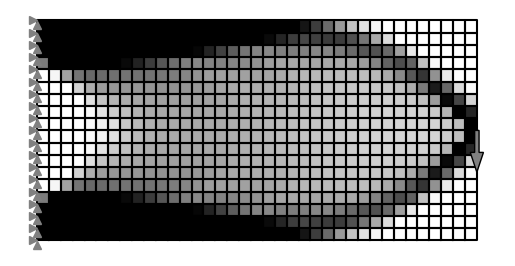

In [4]:
rho_0 = 0.5 * torch.ones(len(cantilever.elements))
rho_min = 0.1 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)
areas = cantilever.areas()
V0 = 0.5 * torch.inner(rho_max, areas)

rho_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, iter=25)
cantilever.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized.svg", transparent=True, bbox_inches="tight"
)

## SIMP approach for binarization

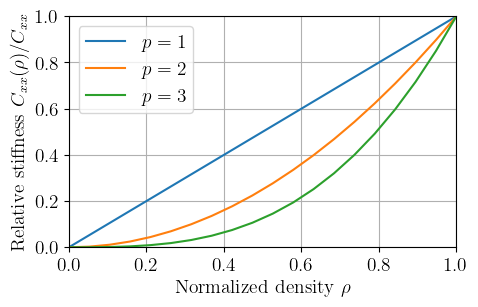

In [5]:
p = 3
Cxx = 1.0

# Plot the SIMP relation
rho = torch.linspace(0, 1, 20)
plt.figure(figsize=(5, 3))
plt.plot(rho, Cxx * rho**1.0, label="$p=1$")
plt.plot(rho, Cxx * rho**2.0, label="$p=2$")
plt.plot(rho, Cxx * rho**3.0, label="$p=3$")
plt.xlabel(r"$\textrm{Normalized density } \rho$")
plt.ylabel(r"$\textrm{Relative stiffness } C_{xx}(\rho)/C_{xx}$")
plt.xlim([0, 1])
plt.ylim([0, Cxx])
plt.legend()
plt.grid()
plt.savefig("../figures/simp.svg", transparent=True, bbox_inches="tight")

Iteration k=  0 - Compliance: 2.86918
Iteration k=  1 - Compliance: 3.08128
Iteration k=  2 - Compliance: 4.41310
Iteration k=  3 - Compliance: 2.54020
Iteration k=  4 - Compliance: 1.33193
Iteration k=  5 - Compliance: 0.93741
Iteration k=  6 - Compliance: 0.80181
Iteration k=  7 - Compliance: 0.75385
Iteration k=  8 - Compliance: 0.73847
Iteration k=  9 - Compliance: 0.72912
Iteration k= 10 - Compliance: 0.72475
Iteration k= 11 - Compliance: 0.72232
Iteration k= 12 - Compliance: 0.71942
Iteration k= 13 - Compliance: 0.71867
Iteration k= 14 - Compliance: 0.71851
Iteration k= 15 - Compliance: 0.71829
Iteration k= 16 - Compliance: 0.71760
Iteration k= 17 - Compliance: 0.71729
Iteration k= 18 - Compliance: 0.71728
Iteration k= 19 - Compliance: 0.71727
Iteration k= 20 - Compliance: 0.71727
Iteration k= 21 - Compliance: 0.71726
Iteration k= 22 - Compliance: 0.71726
Iteration k= 23 - Compliance: 0.71726
Iteration k= 24 - Compliance: 0.71726
Iteration k= 25 - Compliance: 0.71726
Iteration k=

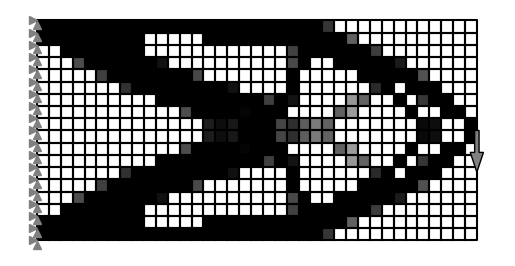

In [6]:
rho_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50)
cantilever.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary.svg", transparent=True, bbox_inches="tight"
)

Iteration k=  0 - Compliance: 2.86918
Iteration k=  1 - Compliance: 3.17674
Iteration k=  2 - Compliance: 4.65593
Iteration k=  3 - Compliance: 2.77356
Iteration k=  4 - Compliance: 1.44732
Iteration k=  5 - Compliance: 0.98896
Iteration k=  6 - Compliance: 0.82821
Iteration k=  7 - Compliance: 0.73155
Iteration k=  8 - Compliance: 0.70437
Iteration k=  9 - Compliance: 0.69566
Iteration k= 10 - Compliance: 0.69019
Iteration k= 11 - Compliance: 0.68774
Iteration k= 12 - Compliance: 0.68603
Iteration k= 13 - Compliance: 0.68483
Iteration k= 14 - Compliance: 0.68392
Iteration k= 15 - Compliance: 0.68365
Iteration k= 16 - Compliance: 0.68252
Iteration k= 17 - Compliance: 0.68268
Iteration k= 18 - Compliance: 0.68183
Iteration k= 19 - Compliance: 0.68188
Iteration k= 20 - Compliance: 0.68161
Iteration k= 21 - Compliance: 0.68135
Iteration k= 22 - Compliance: 0.68148
Iteration k= 23 - Compliance: 0.68111
Iteration k= 24 - Compliance: 0.68142
Iteration k= 25 - Compliance: 0.68105
Iteration k=

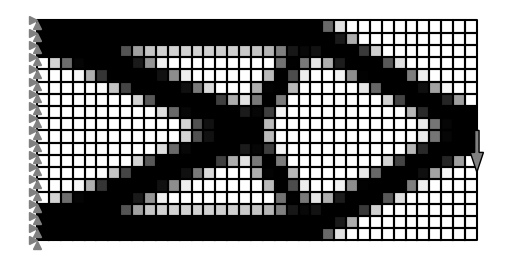

In [7]:
d_opt = optimize_mma(
    cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50, r_sens=1.0
)
cantilever.plot(element_property=d_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 2.89389
Iteration k=  1 - Compliance: 3.05789
Iteration k=  2 - Compliance: 4.47268
Iteration k=  3 - Compliance: 2.78546
Iteration k=  4 - Compliance: 1.38561
Iteration k=  5 - Compliance: 1.01617
Iteration k=  6 - Compliance: 0.81456
Iteration k=  7 - Compliance: 0.74786
Iteration k=  8 - Compliance: 0.72406
Iteration k=  9 - Compliance: 0.71453
Iteration k= 10 - Compliance: 0.70716
Iteration k= 11 - Compliance: 0.70358
Iteration k= 12 - Compliance: 0.70221
Iteration k= 13 - Compliance: 0.70093
Iteration k= 14 - Compliance: 0.70020
Iteration k= 15 - Compliance: 0.69943
Iteration k= 16 - Compliance: 0.69829
Iteration k= 17 - Compliance: 0.69756
Iteration k= 18 - Compliance: 0.69732
Iteration k= 19 - Compliance: 0.69708
Iteration k= 20 - Compliance: 0.69704
Iteration k= 21 - Compliance: 0.69701
Iteration k= 22 - Compliance: 0.69694
Iteration k= 23 - Compliance: 0.69676
Iteration k= 24 - Compliance: 0.69675
Iteration k= 25 - Compliance: 0.69672
Iteration k=

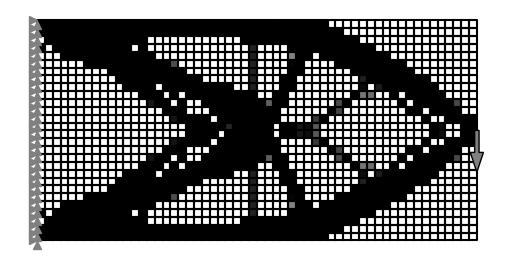

In [8]:
cantilever_fine = get_cantilever(0.5, 28.0, 14.0)

rho_0_f = 0.5 * torch.ones(len(cantilever_fine.elements))
rho_min_f = 0.1 * torch.ones_like(rho_0_f)
rho_max_f = 1.0 * torch.ones_like(rho_0_f)
areas_f = cantilever_fine.areas()
V0 = 0.5 * torch.inner(rho_max_f, areas_f)


rho_opt = optimize_mma(cantilever_fine, rho_0_f, rho_min_f, rho_max_f, V0, p=3, iter=50)
cantilever_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_fine.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 2.89389
Iteration k=  1 - Compliance: 3.14369
Iteration k=  2 - Compliance: 4.71849
Iteration k=  3 - Compliance: 2.92068
Iteration k=  4 - Compliance: 1.44726
Iteration k=  5 - Compliance: 1.03438
Iteration k=  6 - Compliance: 0.86190
Iteration k=  7 - Compliance: 0.74912
Iteration k=  8 - Compliance: 0.71043
Iteration k=  9 - Compliance: 0.70101
Iteration k= 10 - Compliance: 0.69437
Iteration k= 11 - Compliance: 0.69037
Iteration k= 12 - Compliance: 0.68799
Iteration k= 13 - Compliance: 0.68536
Iteration k= 14 - Compliance: 0.68443
Iteration k= 15 - Compliance: 0.68343
Iteration k= 16 - Compliance: 0.68288
Iteration k= 17 - Compliance: 0.68260
Iteration k= 18 - Compliance: 0.68212
Iteration k= 19 - Compliance: 0.68172
Iteration k= 20 - Compliance: 0.68196
Iteration k= 21 - Compliance: 0.68144
Iteration k= 22 - Compliance: 0.68147
Iteration k= 23 - Compliance: 0.68118
Iteration k= 24 - Compliance: 0.68111
Iteration k= 25 - Compliance: 0.68102
Iteration k=

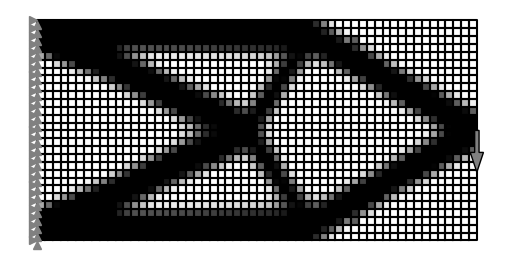

In [9]:
rho_opt = optimize_mma(
    cantilever_fine, rho_0_f, rho_min_f, rho_max_f, V0, p=3, iter=50, r_sens=1.0
)
cantilever_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_fine_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 2.92951
Iteration k=  1 - Compliance: 3.04506
Iteration k=  2 - Compliance: 4.47120
Iteration k=  3 - Compliance: 2.86682
Iteration k=  4 - Compliance: 1.54084
Iteration k=  5 - Compliance: 1.09779
Iteration k=  6 - Compliance: 0.86814
Iteration k=  7 - Compliance: 0.76901
Iteration k=  8 - Compliance: 0.72511
Iteration k=  9 - Compliance: 0.70469
Iteration k= 10 - Compliance: 0.69307
Iteration k= 11 - Compliance: 0.68591
Iteration k= 12 - Compliance: 0.68183
Iteration k= 13 - Compliance: 0.67880
Iteration k= 14 - Compliance: 0.67638
Iteration k= 15 - Compliance: 0.67507
Iteration k= 16 - Compliance: 0.67450
Iteration k= 17 - Compliance: 0.67397
Iteration k= 18 - Compliance: 0.67351
Iteration k= 19 - Compliance: 0.67306


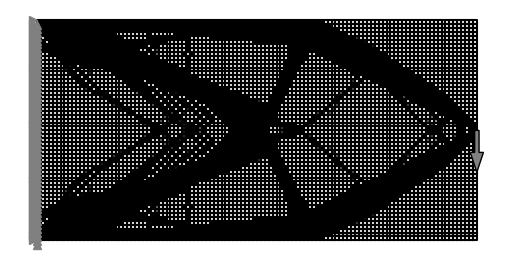

In [10]:
cantilever_extra_fine = get_cantilever(0.25, 28.0, 14.0)

rho_0_xf = 0.5 * torch.ones(len(cantilever_extra_fine.elements))
rho_min_xf = 0.1 * torch.ones_like(rho_0_xf)
rho_max_xf = 1.0 * torch.ones_like(rho_0_xf)
areas_xf = cantilever_extra_fine.areas()
V0 = 0.5 * torch.inner(rho_max_xf, areas_xf)


rho_opt = optimize_mma(
    cantilever_extra_fine, rho_0_xf, rho_min_xf, rho_max_xf, V0, p=3, iter=20
)
cantilever_extra_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_extra_fine.svg",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 2.92951
Iteration k=  1 - Compliance: 3.14448
Iteration k=  2 - Compliance: 4.76767
Iteration k=  3 - Compliance: 2.98869
Iteration k=  4 - Compliance: 1.55470
Iteration k=  5 - Compliance: 1.09041
Iteration k=  6 - Compliance: 0.87434
Iteration k=  7 - Compliance: 0.77099
Iteration k=  8 - Compliance: 0.73227
Iteration k=  9 - Compliance: 0.71448
Iteration k= 10 - Compliance: 0.70482
Iteration k= 11 - Compliance: 0.69964
Iteration k= 12 - Compliance: 0.69638
Iteration k= 13 - Compliance: 0.69410
Iteration k= 14 - Compliance: 0.69268
Iteration k= 15 - Compliance: 0.69154
Iteration k= 16 - Compliance: 0.69056
Iteration k= 17 - Compliance: 0.69001
Iteration k= 18 - Compliance: 0.68953
Iteration k= 19 - Compliance: 0.68913
Iteration k= 20 - Compliance: 0.68875
Iteration k= 21 - Compliance: 0.68871
Iteration k= 22 - Compliance: 0.68829
Iteration k= 23 - Compliance: 0.68838
Iteration k= 24 - Compliance: 0.68818
Iteration k= 25 - Compliance: 0.68788
Iteration k=

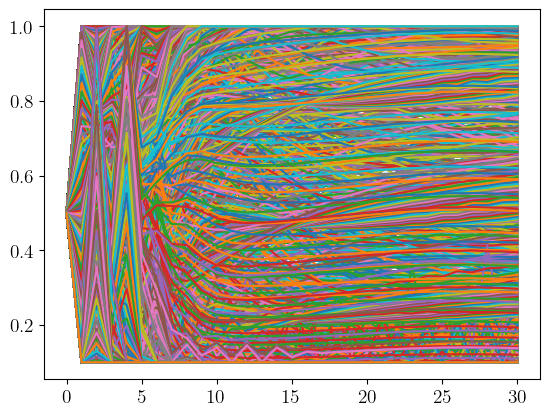

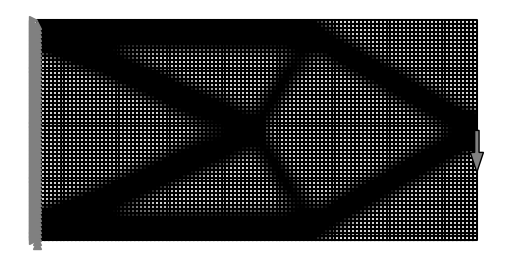

In [11]:
rho_opt = optimize_mma(
    cantilever_extra_fine, rho_0_xf, rho_min_xf, rho_max_xf, V0, p=3, iter=30, r_sens=1.0
)
plt.plot(torch.stack(rho_opt))
plt.show()
cantilever_extra_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "../figures/cantilever_fem_optimized_binary_extra_fine_filtered.svg",
    transparent=True,
    bbox_inches="tight",
)

## Optimization with optimality conditions

In [12]:
def optimize_oc(
    fem, rho_0, rho_min, rho_max, V_0, iter=15, xi=0.5, m=0.2, p=1.0, r_sens=0.0
):
    rho = [rho_0]
    areas = fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r_sens > 0.0:
        H = r_sens - fem.dist
        H[fem.dist > r_sens] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = rho[k] ** p
        # Compute solution
        u_k, f_k = fem.solve()
        # Copy original rho
        rho_k = rho[k].clone()

        # Compute sensitivities
        sensitivity = -p * rho[k] ** (p - 1) * 2.0 * fem.element_strain_energies(u_k)

        # Filter sensitivities (if r_filt provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        def make_step(mu):
            # Assuming a certain value of mu, apply the iteration scheme to
            G_k = -sensitivity / (mu * areas)
            upper = torch.min(rho_max, (1 + m) * rho_k)
            lower = torch.max(rho_min, (1 - m) * rho_k)
            rho_trial = G_k**xi * rho_k
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, areas) - V_0

        mu = bisection(g, 1e-10, 1.0, tol=1e-15)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

Iteration k=0 - Compliance: 2.86918
Iteration k=1 - Compliance: 2.12199
Iteration k=2 - Compliance: 1.69972
Iteration k=3 - Compliance: 1.40273
Iteration k=4 - Compliance: 1.19173
Iteration k=5 - Compliance: 1.10177
Iteration k=6 - Compliance: 1.03269
Iteration k=7 - Compliance: 0.96723
Iteration k=8 - Compliance: 0.91409
Iteration k=9 - Compliance: 0.86997
Iteration k=10 - Compliance: 0.82936
Iteration k=11 - Compliance: 0.79228
Iteration k=12 - Compliance: 0.75998
Iteration k=13 - Compliance: 0.73506
Iteration k=14 - Compliance: 0.71777
Iteration k=15 - Compliance: 0.70544
Iteration k=16 - Compliance: 0.69679
Iteration k=17 - Compliance: 0.69099
Iteration k=18 - Compliance: 0.68749
Iteration k=19 - Compliance: 0.68567
Iteration k=20 - Compliance: 0.68446
Iteration k=21 - Compliance: 0.68365
Iteration k=22 - Compliance: 0.68308
Iteration k=23 - Compliance: 0.68270
Iteration k=24 - Compliance: 0.68239
Iteration k=25 - Compliance: 0.68213
Iteration k=26 - Compliance: 0.68193
Iteration k

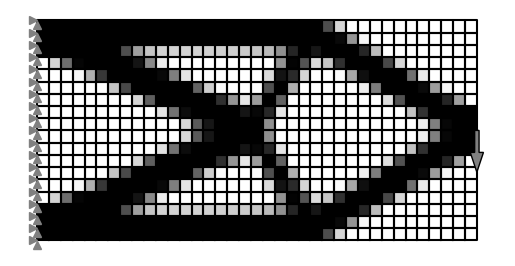

In [13]:
rho_opt = optimize_oc(cantilever, rho_0, rho_min, rho_max, V0, p=3, iter=50, r_sens=1.0)
cantilever.plot(element_property=rho_opt[-1])